Initialization

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk import ngrams
import nltk
from datasets import load_dataset
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, BartTokenizer, BartForConditionalGeneration
# Download NLTK data (only if needed)
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Potato\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Potato\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-small")
tokenizer_bart = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model_bart = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
small_dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1%]")

C:\Users\Potato\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ETDA

Number of articles: 2871
Average article length (words): 606.76
Average summary length (words): 43.50


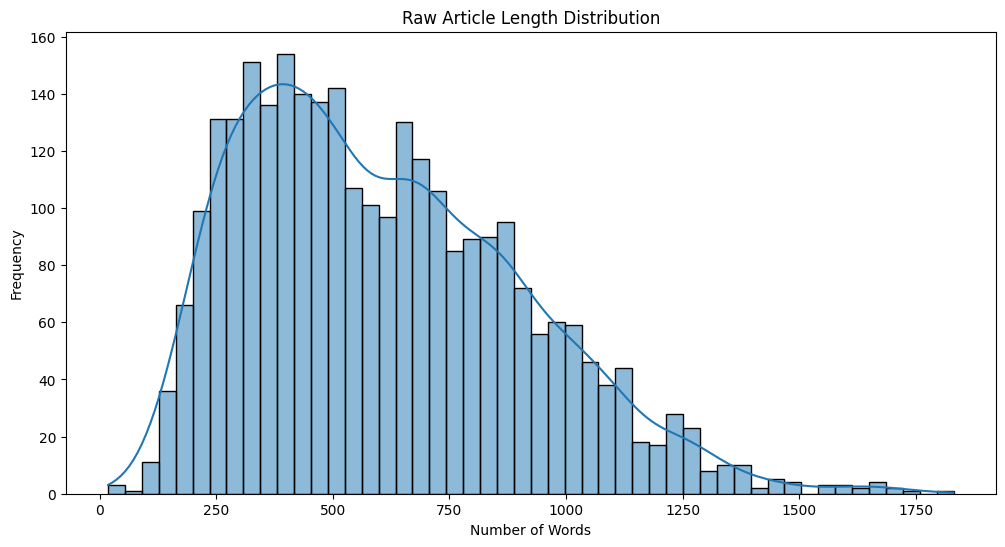

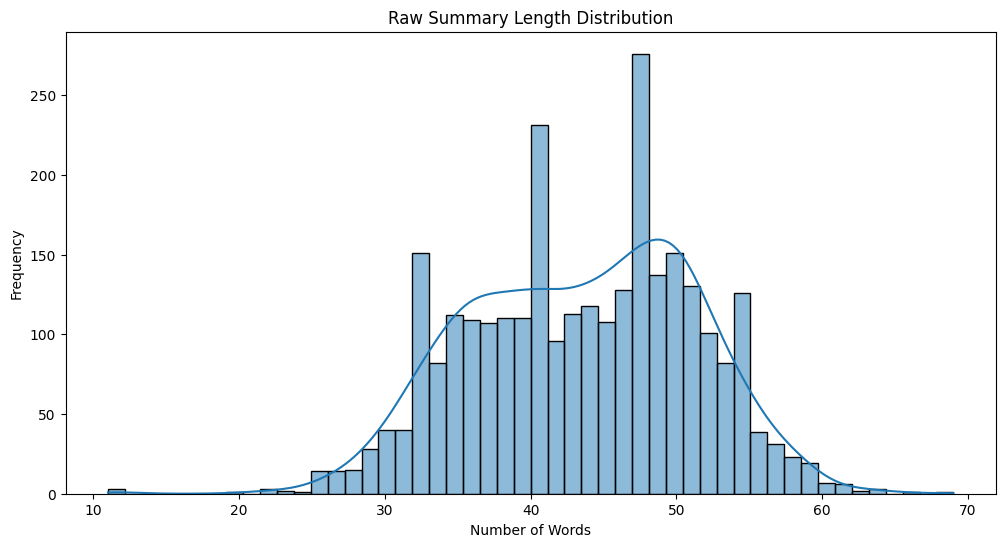

Null values in dataset:
article           0
summary           0
article_length    0
summary_length    0
dtype: int64
Empty articles: 0
Empty summaries: 0


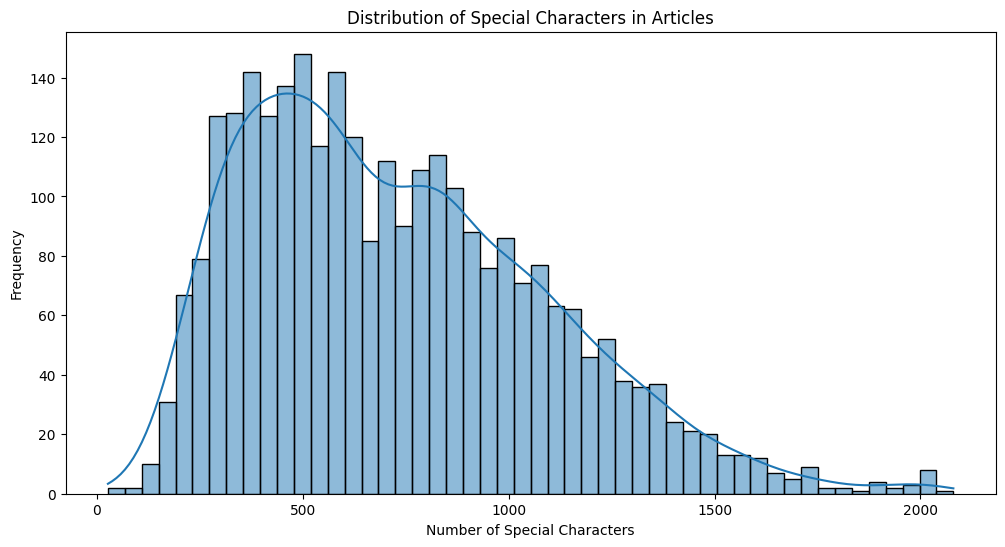

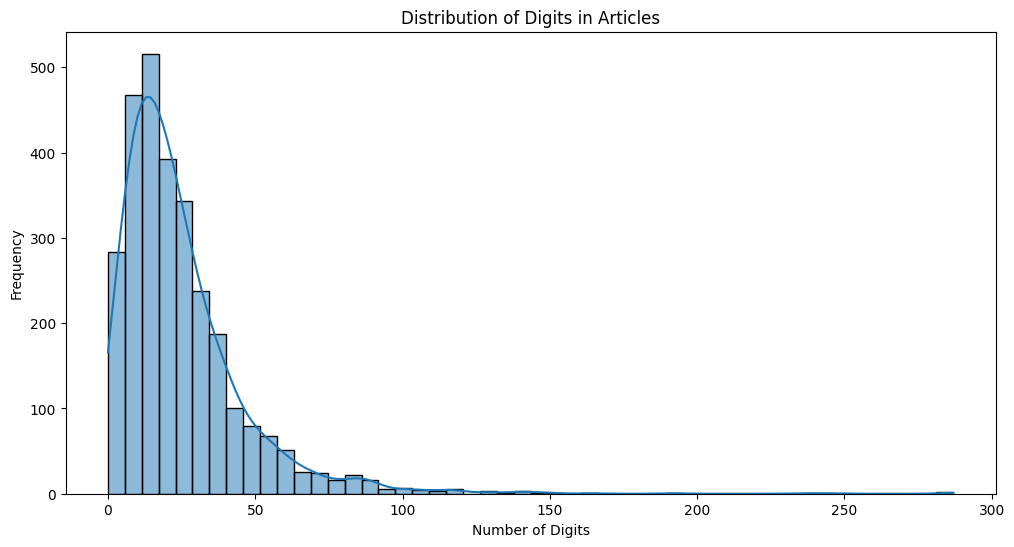

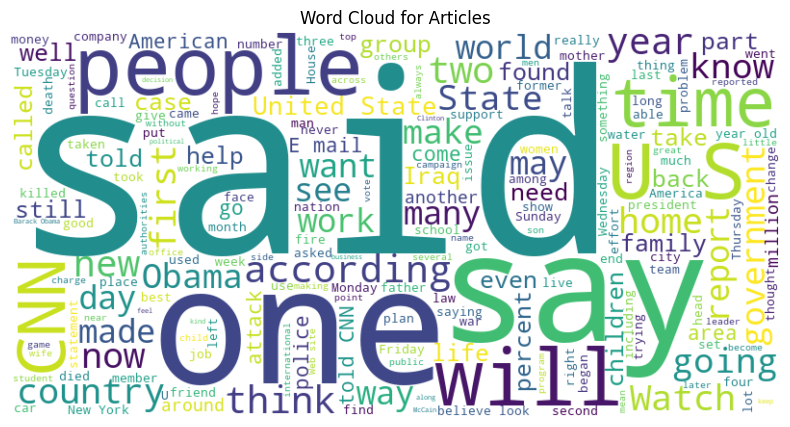

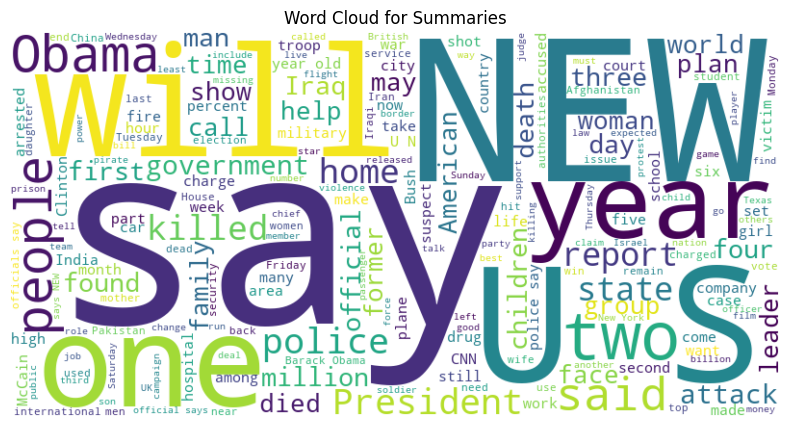

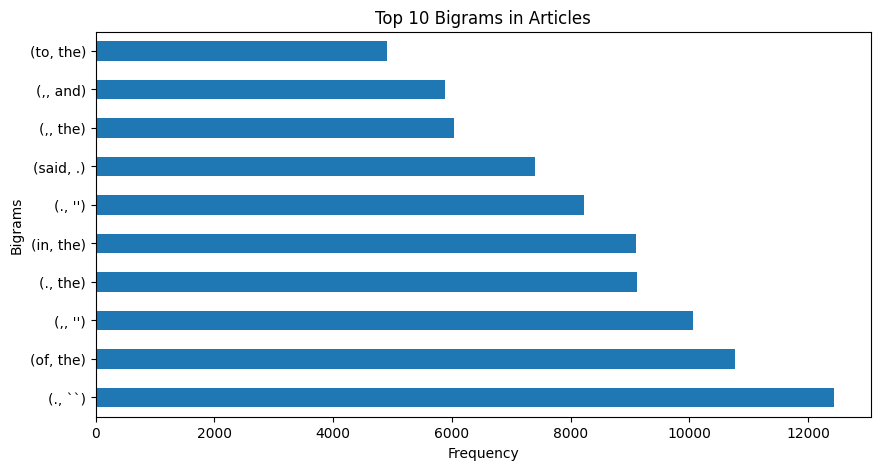

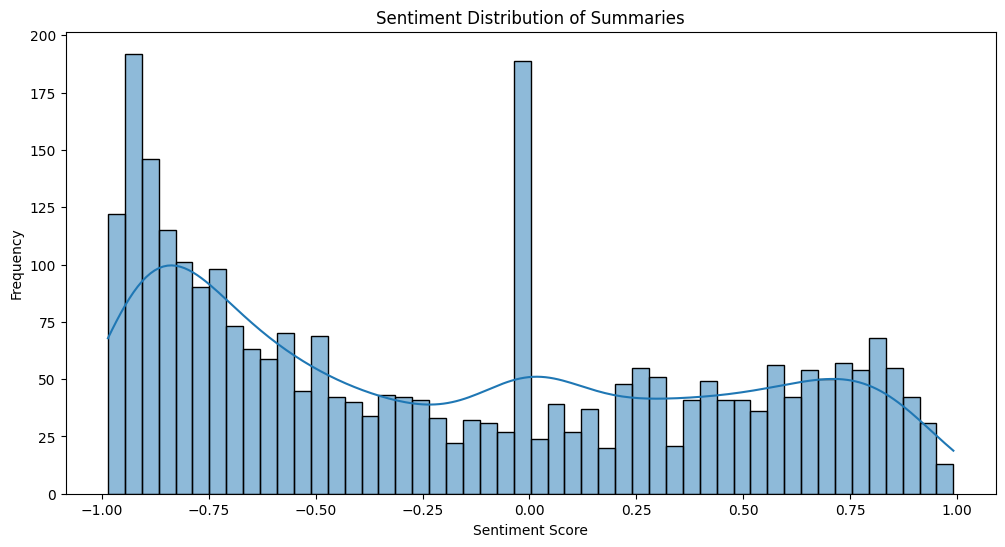

In [24]:
df = pd.DataFrame({
    'article': small_dataset['article'],
    'summary': small_dataset['highlights']
})
# Dataset size
print(f"Number of articles: {len(df)}")

# Dataset lengths
df['article_length'] = df['article'].apply(lambda x: len(x.split()))
df['summary_length'] = df['summary'].apply(lambda x: len(x.split()))

print(f"Average article length (words): {df['article_length'].mean():.2f}")
print(f"Average summary length (words): {df['summary_length'].mean():.2f}")

plt.figure(figsize=(12, 6))
sns.histplot(df['article_length'], bins=50, kde=True)
plt.title('Raw Article Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['summary_length'], bins=50, kde=True)
plt.title('Raw Summary Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Missing or Null Data Analysis
print("Null values in dataset:")
print(df.isnull().sum())

print("Empty articles:", sum(df['article'] == ''))
print("Empty summaries:", sum(df['summary'] == ''))

# Special Characters and Digit Distribution
df['num_special_chars'] = df['article'].apply(lambda x: sum(not char.isalnum() for char in x))
df['num_digits'] = df['article'].apply(lambda x: sum(char.isdigit() for char in x))

plt.figure(figsize=(12, 6))
sns.histplot(df['num_special_chars'], bins=50, kde=True)
plt.title('Distribution of Special Characters in Articles')
plt.xlabel('Number of Special Characters')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['num_digits'], bins=50, kde=True)
plt.title('Distribution of Digits in Articles')
plt.xlabel('Number of Digits')
plt.ylabel('Frequency')
plt.show()

# Word Cloud for articles
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['article']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Articles')
plt.show()

# Word Cloud for summaries
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['summary']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Summaries')
plt.show()

# N-grams Analysis
def get_ngrams(text, n):
    tokens = nltk.word_tokenize(text.lower())
    return list(ngrams(tokens, n))

bigrams = df['article'].apply(get_ngrams, n=2).explode()
bigram_freq = bigrams.value_counts().head(10)

bigram_freq.plot(kind='barh', figsize=(10, 5), title='Top 10 Bigrams in Articles')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

# Sentiment Analysis 
sia = SentimentIntensityAnalyzer()
df['summary_sentiment'] = df['summary'].apply(lambda x: sia.polarity_scores(x)['compound'])

plt.figure(figsize=(12, 6))
sns.histplot(df['summary_sentiment'], bins=50, kde=True)
plt.title('Sentiment Distribution of Summaries')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Trials Runs

In [ ]:
def bart_batch_preprocess(examples, max_length=1024):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer_bart(
        inputs,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    labels = tokenizer_bart(examples["highlights"], max_length=150, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def t5_batch_preprocess(examples, max_length=1024):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer_t5(
        inputs,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    labels = tokenizer_t5(examples["highlights"], max_length=150, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [34]:
def bart_preprocess(article: str, max_length: int = 1024):
    tokenized_input = tokenizer_bart(
        article,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    return tokenized_input

def t5_preprocess(article: str, max_length: int = 1024):
    tokenized_input = tokenizer_t5(
        article,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    return tokenized_input

In [35]:
def bart_generate_summary(article: str, max_input_length: int = 1024, max_summary_length: int = 150):
    tokenized_input = bart_preprocess(article, max_length=max_input_length)
    
    summary_ids = model_bart.generate(
        tokenized_input['input_ids'],
        max_length=max_summary_length,
        min_length=30,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def t5_generate_summary(article: str, max_input_length: int = 1024, max_summary_length: int = 150):
    tokenized_input = t5_preprocess(article, max_length=max_input_length)
    
    summary_ids = model_t5.generate(
        tokenized_input['input_ids'],
        max_length=max_summary_length,
        min_length=30,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    summary = tokenizer_t5.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [39]:
print("Original text")
print(small_dataset['article'][0])

summary = bart_generate_summary(small_dataset['article'][0])
print("Generated Bart Summary:")
print(summary)

summary = t5_generate_summary(small_dataset['article'][0])
print("Generated T5 Summary:")
print(summary)

Original text
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. 